## Modelo de regresion logistica Base

In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, fbeta_score, roc_curve
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
data_path = "../data/fraud_train.csv"
df = pd.read_csv(data_path)

Se hacen las transformaciones resultado del analisis exploratorio

In [3]:
df = df[
    [
        'Month',
         'DayOfWeek',
         'Make',
         'AccidentArea',
         'MonthClaimed',
         'WeekOfMonthClaimed',
         'MaritalStatus',
         'Fault',
         'PolicyType',
         'VehicleCategory',
         'VehiclePrice',
         'Deductible',
         'PastNumberOfClaims',
         'AgeOfVehicle',
         'AgeOfPolicyHolder',
         'AgentType',
         'NumberOfSuppliments',
         'AddressChange_Claim',
         'BasePolicy',
         'FraudFound_P'
    ]
]

In [4]:
replace_map = {
    'Porche': 'Luxyry',
    'Ferrari': 'Luxyry',
    'Mecedes': 'Luxyry'
}

# Aplica el reemplazo
df_final = df.copy()
df_final['Make'] = df_final['Make'].replace(replace_map)

Creamos los conjuntos de entrenamiento y validacion

In [5]:
X = df_final.drop('FraudFound_P', axis=1)
y = df_final['FraudFound_P']

In [6]:
X, X_val, y, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

Calculo del scorecard

In [7]:
def generate_scorecard(model, encoder, pdo=20, base_score=600, base_odds=50):
    # Coeficientes del modelo
    coef = model.named_steps["model"].coef_[0]
    intercept = model.named_steps["model"].intercept_[0]
    variables = encoder.get_feature_names_out()

    # Cálculo del factor y offset
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(base_odds)

    scorecard = []

    # Iterar sobre cada variable transformada
    for i, var in enumerate(variables):
        # Obtener los valores WOE de cada categoría
        orig_var = var.split("_")[0]  # nombre de la variable original
        woe_map = encoder.category_mapping[encoder.feature_names_in_.tolist().index(orig_var)]['mapping']
        
        points_per_category = {k: -coef[i] * factor * v for k, v in woe_map.items()}

        scorecard.append({
            "variable": var,
            "coef": coef[i],
            "points_per_unit_woe": -coef[i] * factor,
            "points_per_category": points_per_category
        })

    return scorecard, intercept, factor, offset

def score_from_prob(prob, factor, offset):
    odds = prob / (1 - prob)
    return offset - factor * np.log(odds)

Optimizacion de hiperparametros con optuna para C y max_iter usando como metrica el fbeta score ya que estre prioriza el recall lo cual en un caso de deteccion de fraude es bueno ya que queremos detectar todos los verdaderos positivos a costa de tener algunos falsos positivos

In [8]:
def objective(trial):
    # Hiperparámetros del modelo
    C = trial.suggest_float("C", 0.001, 10.0, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 1000)

    pipeline = Pipeline([
        ("woe", ce.WOEEncoder()),
        ("model", LogisticRegression(C=C, max_iter=max_iter, solver="lbfgs"))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


    y_prob = cross_val_predict(pipeline, X, y, cv=cv, method="predict_proba")[:, 1]

    # Aplicar threshold sugerido por Optuna
    y_pred = (y_prob >= 0.5).astype(int)

    # Métrica a maximizar
    return fbeta_score(y, y_pred, beta=2)

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Mejores params:", best_params)

[I 2025-08-14 04:37:07,649] A new study created in memory with name: no-name-e30a4845-4ddd-4138-8cba-b943e2c022a1
[I 2025-08-14 04:37:08,435] Trial 0 finished with value: 0.0 and parameters: {'C': 0.003688791216876659, 'max_iter': 594}. Best is trial 0 with value: 0.0.
[I 2025-08-14 04:37:09,950] Trial 1 finished with value: 0.0 and parameters: {'C': 0.24230903114984595, 'max_iter': 286}. Best is trial 0 with value: 0.0.
[I 2025-08-14 04:37:10,955] Trial 2 finished with value: 0.0 and parameters: {'C': 0.19432297890507316, 'max_iter': 758}. Best is trial 0 with value: 0.0.
[I 2025-08-14 04:37:11,925] Trial 3 finished with value: 0.0 and parameters: {'C': 0.09641990103688695, 'max_iter': 269}. Best is trial 0 with value: 0.0.
[I 2025-08-14 04:37:13,075] Trial 4 finished with value: 0.0047169811320754715 and parameters: {'C': 5.808393579329183, 'max_iter': 871}. Best is trial 4 with value: 0.0047169811320754715.
[I 2025-08-14 04:37:13,867] Trial 5 finished with value: 0.0 and parameters:

Mejores params: {'C': 8.598340263469439, 'max_iter': 116}


Entrenamiento del modelo con los parametros optimos

In [10]:
pipeline = Pipeline(steps=[
    ("woe", ce.WOEEncoder()),
    ("model", LogisticRegression(**best_params, class_weight="balanced", solver="lbfgs"))
])

pipeline.fit(X, y)

encoder = pipeline.named_steps["woe"]
scorecard, intercept, factor, offset = generate_scorecard(pipeline, encoder)

y_prob_val = pipeline.predict_proba(X_val)[:, 1]
y_score_val = score_from_prob(y_prob_val, factor, offset)
y_pred_val = (y_prob_val >= 0.5).astype(int)


auc = roc_auc_score(y_val, y_prob_val)
fpr, tpr, _ = roc_curve(y_val, y_prob_val)
ks = max(tpr - fpr)
fb = fbeta_score(y_val, y_pred_val, beta=2)

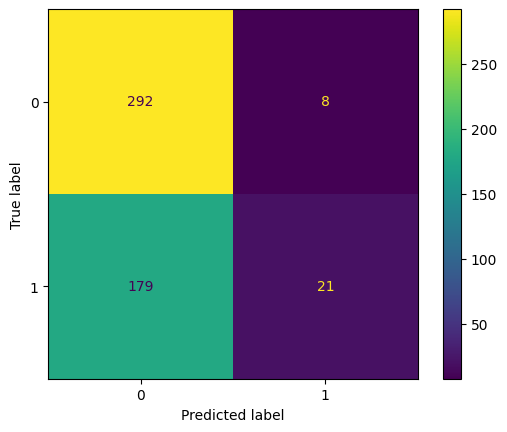

In [11]:
cm = confusion_matrix(y_pred_val, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [12]:
print(auc)
print(ks)
print(fb)

0.7685774946921444
0.4899333772604144
0.3322784810126582


In [13]:
pd.DataFrame(scorecard)

,variable,coef,points_per_unit_woe
0,Month,0.767974,-22.159059
1,DayOfWeek,1.010773,-29.164747
2,Make,0.612275,-17.666512
3,AccidentArea,0.672985,-19.418249
4,MonthClaimed,0.524821,-15.143123
5,WeekOfMonthClaimed,0.072999,-2.106318
6,MaritalStatus,0.301227,-8.691566
7,Fault,1.413093,-40.773239
8,PolicyType,0.646358,-18.649954
9,VehicleCategory,-0.317296,9.155234


In [14]:
import pickle

mlflow.set_tracking_uri("http://mlflow:5000")
model_name = 'lr_base'
mlflow.set_experiment("fraud_detection")
with mlflow.start_run(run_name=model_name):
    mlflow.log_params(best_params)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("KS", ks)
    mlflow.log_metric("Fbeta", fb)
    pd.DataFrame(scorecard).to_csv(model_name+"scorecard.csv", index=False)
    with open(model_name+"lr_model.pkl", "wb") as f:
        pickle.dump(pipeline, f)
    mlflow.log_artifact(model_name+"scorecard.csv")
    mlflow.log_artifact(model_name+"lr_model.pkl")
    plt.savefig(model_name+"confusion_matrix.png")
    plt.close()
    mlflow.log_artifact(model_name+"confusion_matrix.png")

2025/08/14 04:37:29 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection' does not exist. Creating a new experiment.


🏃 View run lr_base at: http://mlflow:5000/#/experiments/1/runs/5324911c0fa649798464866bb60214d1
🧪 View experiment at: http://mlflow:5000/#/experiments/1
